In [1]:
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import GroverOperator, Diagonal
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, Batch, SamplerV2 as Sampler

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_sherbrooke'

### Mapping the problem

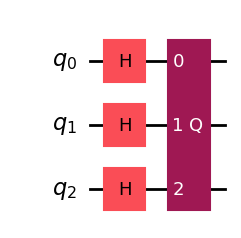

In [2]:
## Example Problem: Grover's Algorithm to mark '111'

oracle = Diagonal([1] * 7 + [-1])
qc = QuantumCircuit(3)
qc.h([0,1,2])
qc = qc.compose(GroverOperator(oracle))

qc.draw(output="mpl", style="iqp")

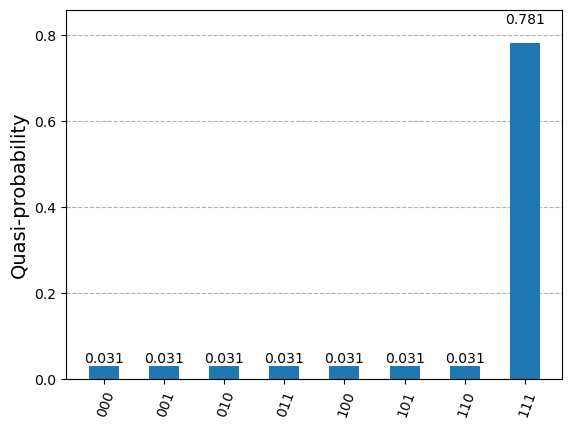

In [3]:
ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()

plot_histogram(ideal_distribution)

### Optimize for quantum execution

In [6]:
# Comparing different settings of transpilation for two-qubit circuits

qc.measure_all()

twoQ_gates = set(['ecr', 'cz', 'cx'])
for gate in backend.basis_gates:
    if gate in twoQ_gates:
        twoQ_gates = gate
        
circuits = []
for optimization_level in [0, 3]:
    pm = generate_preset_pass_manager(optimization_level, backend=backend, seed_transpiler=0)
    t_qc = pm.run(qc)
    print(f"Two-qubit gates at (optimization level = {optimization_level}): ", t_qc.count_ops()[twoQ_gates])
    circuits.append(t_qc)

Two-qubit gates at (optimization level = 0):  27
Two-qubit gates at (optimization level = 3):  14


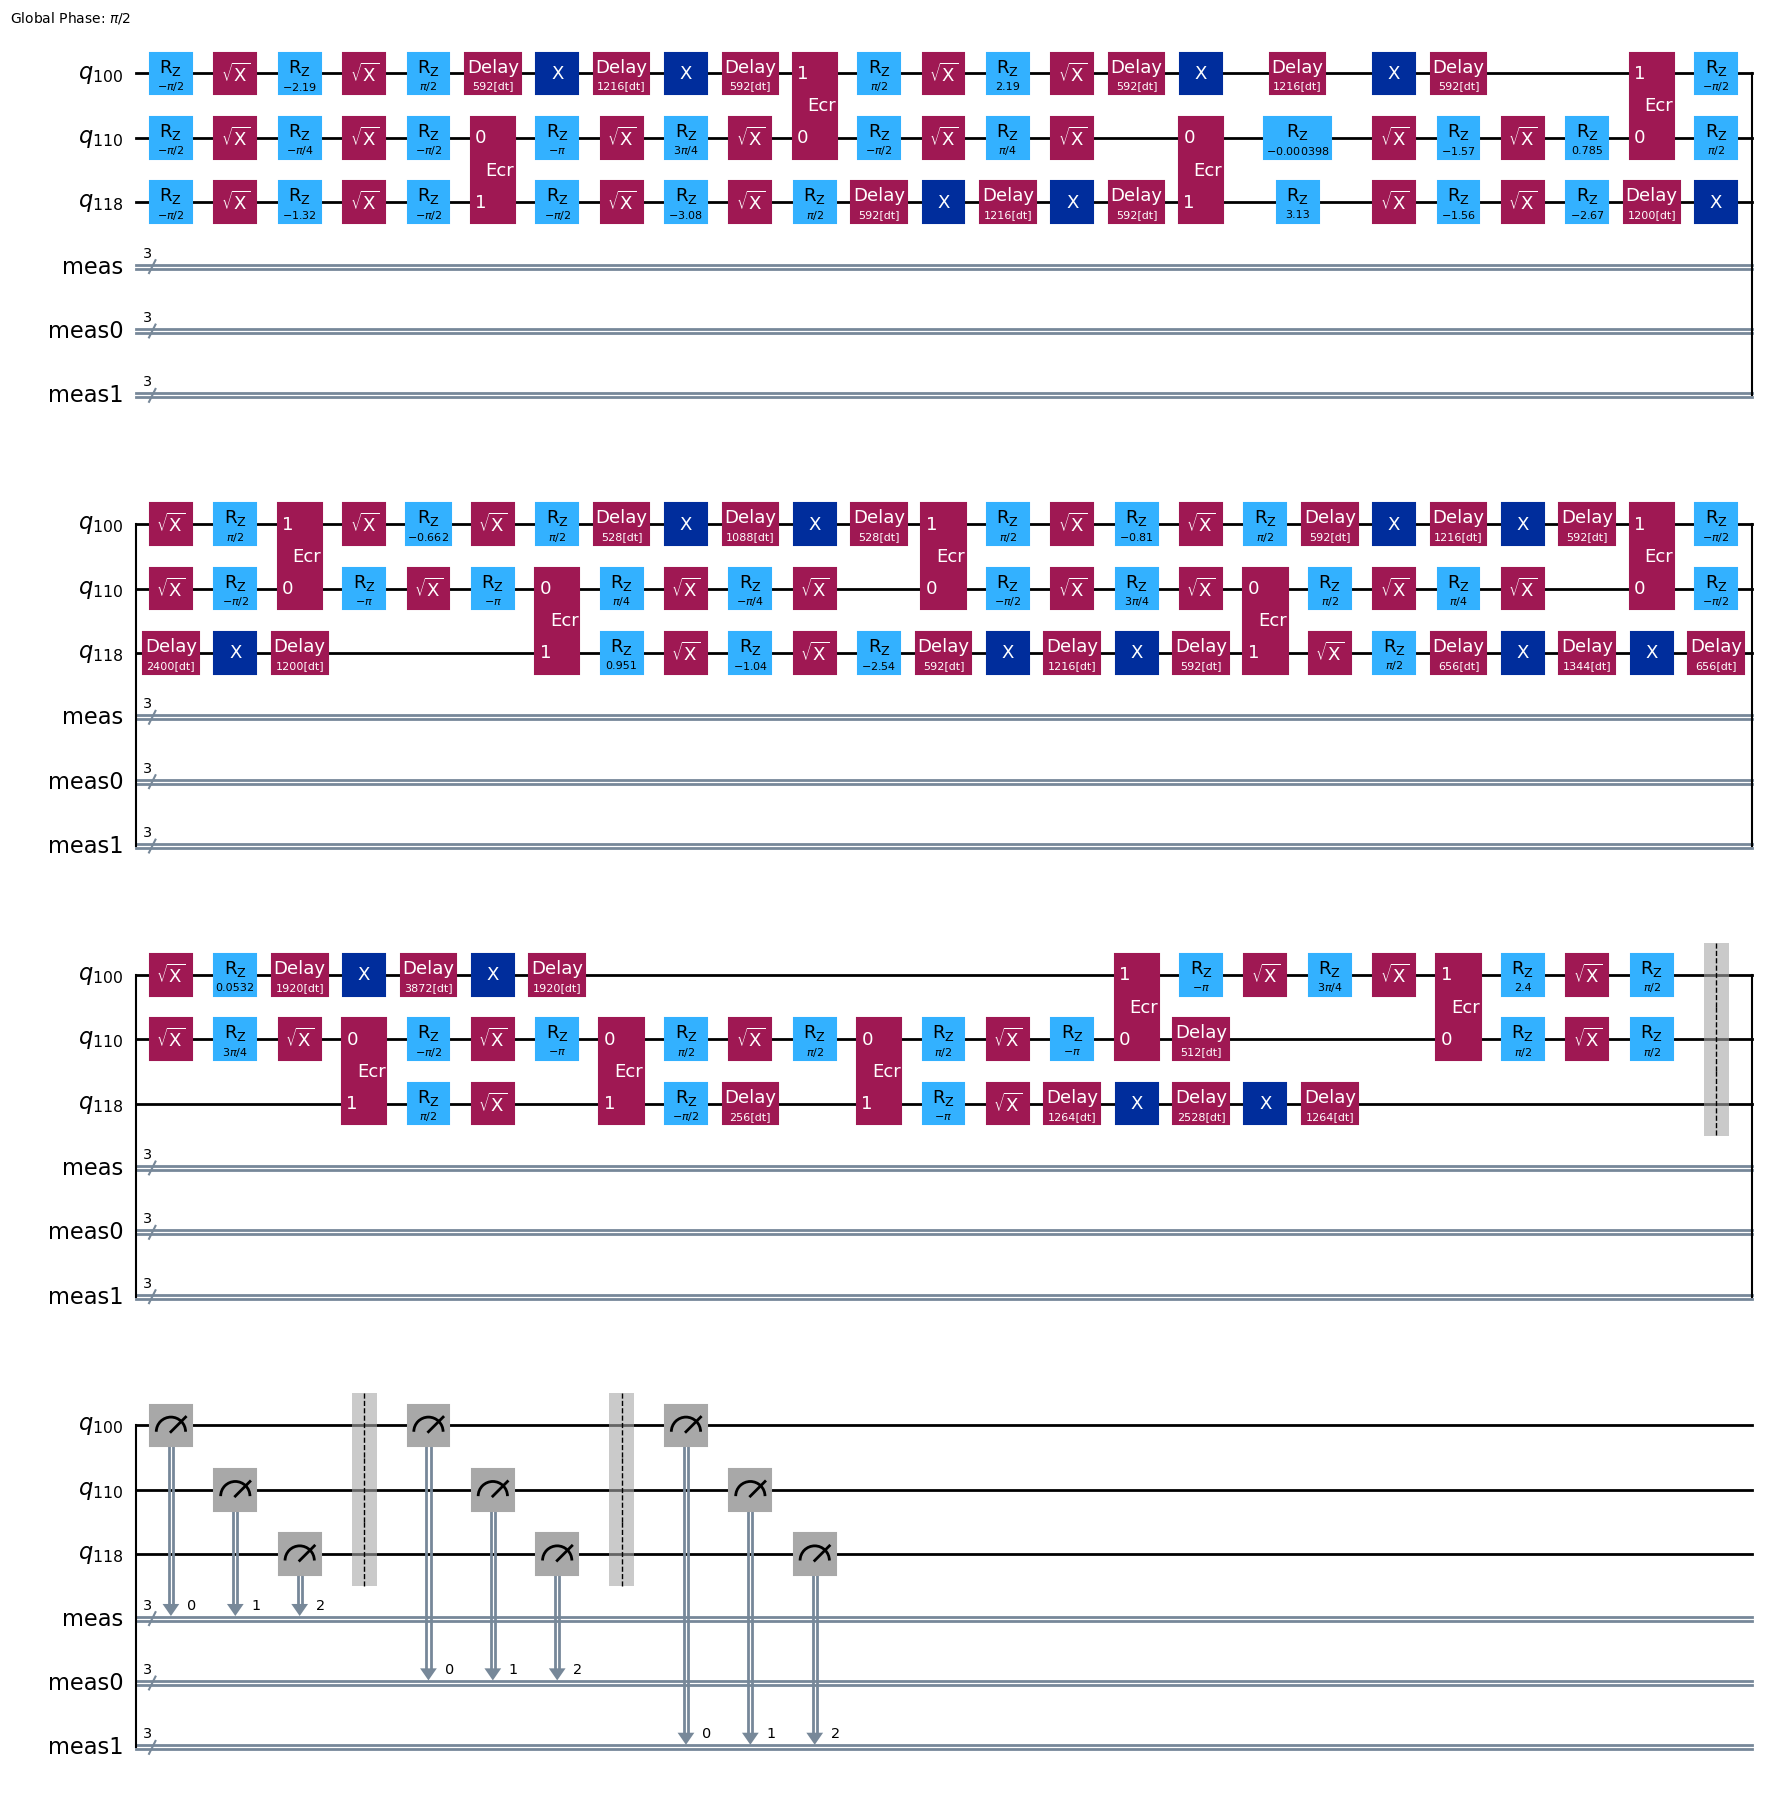

In [11]:
# Dynamic decoupling with Optimization_level = 3

from qiskit.transpiler import PassManager
from qiskit_ibm_runtime.transpiler.passes.scheduling import (ASAPScheduleAnalysis, PadDynamicalDecoupling,)
from qiskit.circuit.library import XGate

durations = backend.target.durations() # operation time at each step
dd_sequence = [XGate(), XGate()] # minimizing environmental degenaration of the system with dynamic decoupling

pm = PassManager([ASAPScheduleAnalysis(durations), PadDynamicalDecoupling(durations, dd_sequence)])
circ_dd = pm.run(circuits[1])

circuits.append(circ_dd)

circ_dd.draw(output="mpl", style="iqp", idle_wires=False)

### Quantum Execution

In [12]:
with Batch(backend=backend):
    sampler = Sampler()
    job = sampler.run([(circuit) for circuit in circuits], shots=8000)
    result = job.result()

### Post-processing

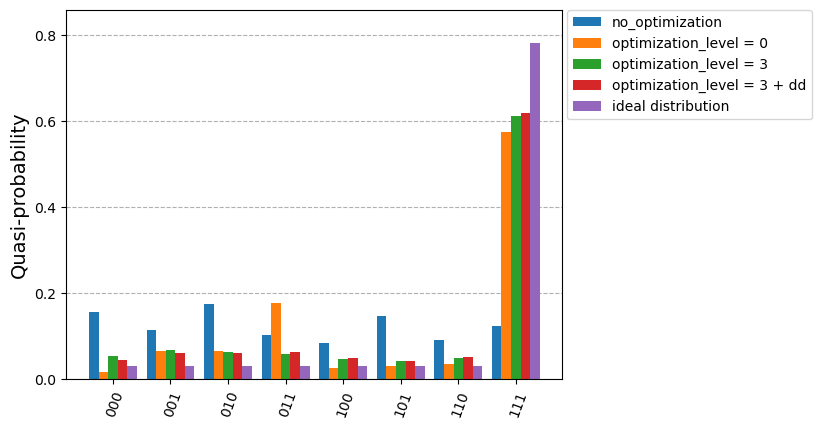

In [20]:
binary_prob = [{k: v/res.data.meas.num_shots for k, v in res.data.meas.get_counts().items()} for res in result]
plot_histogram(
    binary_prob + [ideal_distribution], bar_labels=False,
    legend=[
        "no_optimization",
        "optimization_level = 0",
        "optimization_level = 3",
        "optimization_level = 3 + dd",
        "ideal distribution",
    ],)

In [19]:
# Computing the Hellinger distances between the probabilities under various optimizations and ideal_distribution.
from qiskit.quantum_info import hellinger_fidelity

for prob in binary_prob:
    print(f"{hellinger_fidelity(prob, ideal_distribution):.3f}")

0.557
0.911
0.964
0.967
